In [157]:
from paddleocr import PaddleOCR

class PaddleModel:

    def __init__(self, device: int = 0) -> None:
        self.model = PaddleOCR(
            use_angle_cls=True,
            lang="en",
            show_log=True,
            det_db_score_mode="slow",
            ocr_version="PP-OCRv4",
            rec_algorithm="SVTR_LCNet",
            drop_score=0.5,
            use_gpu=True,
            gpu_id=device,
            gpu_mem=1000,
        )

In [158]:
import json
import tqdm
import math
import numpy as np


def get_unique_moments_from_statvu(statvu_log_path):
    """
    Extracts unique moments from a StatVu log file.

    Args:
    statvu_log_path (str): The file path of the StatVu log.

    Returns:
    dict: A dictionary mapping unique quarter-time remaining combinations to their respective moment details.
    """
    with open(statvu_log_path, "r") as file:
        data = json.load(file)

    unique_quarter_time_combinations = set()
    processed_moments = {}

    for event in data["events"]:
        for moment in event["moments"]:
            (
                quarter,
                moment_id,
                time_remaining_quarter,
                time_remaining_shot_clock,
                _,
                positions,
            ) = moment
            moment_identifier = f"{quarter}_{time_remaining_quarter}"
            if moment_identifier not in unique_quarter_time_combinations:
                player_positions = [
                    {
                        "team_id": player_data[0],
                        "player_id": player_data[1],
                        "x_position": player_data[2],
                        "y_position": player_data[3],
                        "z_position": player_data[4],
                    }
                    for player_data in positions
                ]
                processed_moments[moment_identifier] = {
                    "quarter": quarter,
                    "moment_id": moment_id,
                    "time_remaining_in_quarter": time_remaining_quarter,
                    "time_remaining_on_shot_clock": time_remaining_shot_clock,
                    "player_positions": player_positions,
                }
                unique_quarter_time_combinations.add(moment_identifier)

    return processed_moments


def update_timestamps(timestamps, time_remaining):
    for k, v in enumerate(time_remaining):
        timestamps[str(k)]["time_remaining"] = v
    return timestamps


def get_timestamps_from_fp(fp):
    with open(fp, "r") as f:
        timestamps = json.load(f)
    return timestamps


def get_time_remaining_from_timestamps_fp(fp):
    timestamps = get_timestamps_from_fp(fp)
    return get_time_remaining_from_timestamps(timestamps)


def get_time_remaining_from_timestamps(timestamps):
    return np.array(
        [
            v["time_remaining"] if v["time_remaining"] is not None else 0
            for v in timestamps.values()
        ]
    )


def post_process_timestamps(timestamps):

    timestamps = timestamps.copy()

    def extend_timestamps(time_remaining):
        """
        Interpolate timestamps in-place.
        """
        _time_remaining = []
        last_time = 0
        for val in time_remaining:
            if val != None and val > 1:
                last_time = val
            _time_remaining.append(last_time)
        return _time_remaining

    def interpolate(time_remaining):

        time_remaining = time_remaining.copy()
        fps = 30
        multiplier = 0
        decreasing = False
        for i in range(len(time_remaining) - 1):
            current, next_value = time_remaining[i], time_remaining[i + 1]
            peak_value = time_remaining[min(i + fps, len(time_remaining) - 1)]
            if current == 0:
                continue
            decreasing = peak_value < current
            if decreasing:
                if multiplier > 30:
                    multiplier, decreasing = 0, False
                    continue
                time_remaining[i] -= round((1 / 30) * multiplier, 2)
                multiplier = 0 if next_value < current else multiplier + 1
        return time_remaining

    def moving_average(x, window):
        return np.convolve(x, np.ones(window), "valid") / window

    def normalize(arr):
        _min, _max = arr.min(), arr.max()
        return (arr - _min) / (_max - _min)

    def denoise_time_remaining(time_remaining):

        def update_time_remaining(remove_indices, time_remaining):
            valid_indices = np.where(remove_indices == 0)[0]
            for idx in np.where(remove_indices)[0]:
                nearest_valid_index = valid_indices[
                    np.argmin(np.abs(valid_indices - idx))
                ]
                time_remaining[idx] = time_remaining[nearest_valid_index]

        # remove values that deviate too far from expected values
        time_remaining = np.array(time_remaining)
        time_remaining_og = time_remaining.copy()
        expected = np.linspace(100, 720, len(time_remaining), endpoint=False)[::-1]
        norm_expected_diff = normalize(np.abs(expected - time_remaining_og))
        remove_indices = (norm_expected_diff > 0.5).astype(int)
        update_time_remaining(remove_indices, time_remaining)

        # convolve with shrinking window
        for window in [1000, 500]:
            if len(time_remaining) > window:
                mvg_avg = moving_average(time_remaining, window)
                padded_avg = np.pad(
                    mvg_avg, (window // 2, window - window // 2 - 1), mode="edge"
                )
                norm_diff = normalize(np.abs(time_remaining - padded_avg))
                remove_indices = (norm_diff > 0.5).astype(int)
                update_time_remaining(remove_indices, time_remaining)

        # convolve with shrinking window
        for window in [50, 10, 5]:
            if len(time_remaining) > window:
                mvg_avg = moving_average(time_remaining, window)
                padded_avg = np.pad(
                    mvg_avg, (window // 2, window - window // 2 - 1), mode="edge"
                )
                norm_diff = normalize(np.abs(time_remaining - padded_avg))
                remove_indices = (norm_diff > 0.5).astype(int)
                update_time_remaining(remove_indices, time_remaining)

        temp_interpolated = interpolate(time_remaining)
        delta = np.gradient(temp_interpolated)
        delta_inter = normalize(moving_average(abs(delta), 7))
        remove_indices = (delta_inter > 0.1).astype(int)
        update_time_remaining(remove_indices, time_remaining)
        return time_remaining

    def remove_delta_zero(a, b):
        if len(a) != len(b):
            raise ValueError("The arrays 'a' and 'b' must be of equal length.")
        # Iterate through the arrays
        for i in range(len(a)):
            if b[i] == 0:
                a[i] = None
        return a

    time_remaining = get_time_remaining_from_timestamps(timestamps)
    extended_time_remaining = extend_timestamps(time_remaining)
    denoised_time_remaining = denoise_time_remaining(extended_time_remaining)
    interpolated_time_remaining = interpolate(denoised_time_remaining)

    # remove values where delta = 0
    delta_time_remaining = np.gradient(interpolated_time_remaining)
    remove_delta_zero(interpolated_time_remaining, delta_time_remaining)

    timestamps = update_timestamps(
        timestamps=timestamps, time_remaining=interpolated_time_remaining
    )
    return timestamps


def post_process_time_remaining(time_remaining):

    def extend_timestamps(time_remaining):
        """
        Interpolate timestamps in-place.
        """
        _time_remaining = []
        last_time = 0
        for val in time_remaining:
            if val != None and val > 1:
                last_time = val
            _time_remaining.append(last_time)
        return _time_remaining

    def interpolate(time_remaining):

        time_remaining = time_remaining.copy()
        fps = 30
        multiplier = 0
        decreasing = False
        for i in range(len(time_remaining) - 1):
            current, next_value = time_remaining[i], time_remaining[i + 1]
            peak_value = time_remaining[min(i + fps, len(time_remaining) - 1)]
            if current == 0:
                continue
            decreasing = peak_value < current
            if decreasing:
                if multiplier > 30:
                    multiplier, decreasing = 0, False
                    continue
                time_remaining[i] -= round((1 / 30) * multiplier, 2)
                multiplier = 0 if next_value < current else multiplier + 1
        return time_remaining

    def moving_average(x, window):
        return np.convolve(x, np.ones(window), "valid") / window

    def normalize(arr):
        _min, _max = arr.min(), arr.max()
        return (arr - _min) / (_max - _min)

    def denoise_time_remaining(time_remaining):

        def update_time_remaining(remove_indices, time_remaining):
            valid_indices = np.where(remove_indices == 0)[0]
            for idx in np.where(remove_indices)[0]:
                nearest_valid_index = valid_indices[
                    np.argmin(np.abs(valid_indices - idx))
                ]
                time_remaining[idx] = time_remaining[nearest_valid_index]

        # remove values that deviate too far from expected values
        time_remaining = np.array(time_remaining)
        time_remaining_og = time_remaining.copy()
        expected = np.linspace(100, 720, len(time_remaining), endpoint=False)[::-1]
        norm_expected_diff = normalize(np.abs(expected - time_remaining_og))
        remove_indices = (norm_expected_diff > 0.5).astype(int)
        update_time_remaining(remove_indices, time_remaining)

        # convolve with shrinking window
        for window in [1000, 500]:
            if len(time_remaining) > window:
                mvg_avg = moving_average(time_remaining, window)
                padded_avg = np.pad(
                    mvg_avg, (window // 2, window - window // 2 - 1), mode="edge"
                )
                norm_diff = normalize(np.abs(time_remaining - padded_avg))
                remove_indices = (norm_diff > 0.5).astype(int)
                update_time_remaining(remove_indices, time_remaining)

        # convolve with shrinking window
        for window in [50, 10, 5]:
            if len(time_remaining) > window:
                mvg_avg = moving_average(time_remaining, window)
                padded_avg = np.pad(
                    mvg_avg, (window // 2, window - window // 2 - 1), mode="edge"
                )
                norm_diff = normalize(np.abs(time_remaining - padded_avg))
                remove_indices = (norm_diff > 0.5).astype(int)
                update_time_remaining(remove_indices, time_remaining)

        temp_interpolated = interpolate(time_remaining)
        delta = np.gradient(temp_interpolated)
        delta_inter = normalize(moving_average(abs(delta), 7))
        remove_indices = (delta_inter > 0.1).astype(int)
        update_time_remaining(remove_indices, time_remaining)
        return time_remaining

    def remove_delta_zero(a, b):
        if len(a) != len(b):
            raise ValueError("The arrays 'a' and 'b' must be of equal length.")
        # Iterate through the arrays
        for i in range(len(a)):
            if b[i] == 0:
                a[i] = None
        return a

    extended_time_remaining = extend_timestamps(time_remaining)
    denoised_time_remaining = denoise_time_remaining(extended_time_remaining)
    interpolated_time_remaining = interpolate(denoised_time_remaining)

    # remove values where delta = 0
    # delta_time_remaining = np.gradient(interpolated_time_remaining)
    # remove_delta_zero(interpolated_time_remaining, delta_time_remaining)
    return interpolated_time_remaining


def map_frames_to_moments(data, moments_data):
    """
    Maps frames in 'data' to their corresponding moments in 'moments_data' based on time proximity.

    Args:
    data (dict): A dictionary containing data with keys indicating frame identifiers and values
                 having 'quarter' and 'time_remaining' information.
    moments_data (dict): A dictionary where keys are string representations of 'quarter_time' and values
                         are the moments to map.

    Returns:
    dict: A dictionary mapping frame identifiers to corresponding moments in 'moments_data'.
    """

    def is_close(time1, time2, tolerance=0.2):
        """Check if two time values are within a given tolerance."""
        return abs(time1 - time2) <= tolerance

    frames_matched = 0
    total_frames = 0
    frames_moments_map = {}

    moments_dict = {}
    for moment_key in moments_data:
        quarter, time_remaining = map(float, moment_key.split("_"))
        if quarter not in moments_dict:
            moments_dict[quarter] = []
        moments_dict[quarter].append(time_remaining)

    for frame_id in tqdm.tqdm(data):
        quarter_time_key = (
            str(data[frame_id]["quarter"]) + "_" + str(data[frame_id]["time_remaining"])
            if data[frame_id]["time_remaining"] != None
            else None
        )
        if quarter_time_key:
            total_frames += 1
            quarter, time_remaining = map(float, quarter_time_key.split("_"))
            match_found = False
            if quarter in moments_dict:
                closest_time = None
                min_difference = float("inf")
                for moment_time in moments_dict[quarter]:
                    difference = abs(time_remaining - moment_time)
                    if difference < min_difference:
                        min_difference = difference
                        closest_time = moment_time
                # shitty hack
                try:
                    if is_close(time_remaining, closest_time):
                        frames_matched += 1
                        match_found = True
                        moment_key = f"{int(quarter)}_{closest_time}"
                        frames_moments_map[frame_id] = moments_data[moment_key]
                except:
                    pass
            if not match_found:
                frames_moments_map[frame_id] = None
        else:
            frames_moments_map[frame_id] = None

    print(frames_matched, "/", total_frames)
    return frames_moments_map

In [159]:
# !export CUDA_VISIBLE_DEVICES=2,3,4,5,6,7

import concurrent.futures 
import cv2
import torch
import json
import os
import re
import time
import numpy as np
import concurrent
import logging

from tqdm import tqdm
from PIL import Image
from typing import List
from utilities.models import Models

from viz import visualize_timestamps
from utilities.constants import *

MAX_GPUS = 8
ROI_STEP = 5
TIME_REMAINING_STEP = 1

def process_dir(dir_path: str, data_out_path: str, viz_out_path=None):
    """
    Extract all timestamps in a directory,
    return timestamps as dict.
    """

    assert os.path.isdir(
        dir_path), f"Error: bad path to video directory: {dir_path}"
    os.makedirs(data_out_path, exist_ok=True)
    if viz_out_path is not None:
        assert type(
            viz_out_path) is str, "Error: path links must be of type str."
        os.makedirs(viz_out_path, exist_ok=True)

    valid_formats = ['avi', 'mp4']
    vids = os.listdir(dir_path)
    for vid in vids: 
        extension = vid.split(".")[1]
        if extension not in valid_formats:
            vids.remove(vid)

    timestamps = {}
    with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_GPUS) as executor:
        with tqdm(total=len(vids), desc="Processing Videos") as pbar:
            while len(vids) > 0:
                processes = []
                video_paths = []
                for device in range(MAX_GPUS):
                    if len(vids) == 0:
                        break
                    video_path = os.path.join(dir_path, vids[0])
                    data_path = os.path.join(data_out_path, vids[0].replace(
                        ".mp4", ".json").replace(".avi", ".json"))
                    process = executor.submit(extract_timestamps_from_video, video_path, data_path, device=device)
                    processes.append(process)
                    video_paths.append(video_path)  # Store the video_path corresponding to each process
                    vids.remove(vids[0])
                for process, video_path in zip(concurrent.futures.as_completed(processes), video_paths):
                    timestamps[video_path] = process.result()
                    pbar.update(1)
                    
    return timestamps


def extract_timestamps_from_video(video_path: str, save_path: str, device: int = 0):
    """
    Given a path to a basketball broadcast video,
    returns a timestamps dict.
    """

    assert os.path.exists(video_path)

    # print(f"Extracting timestamps for video at {video_path} \n")
    tr_x1, tr_y1, tr_x2, tr_y2 = None, None, None, None

    # TODO: All roi's extracted on device = 0
    time_remaining_roi = extract_roi_from_video(video_path)

    if time_remaining_roi is not None:
        tr_x1, tr_y1, tr_x2, tr_y2 = time_remaining_roi
    cap = cv2.VideoCapture(video_path)
    frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    timestamps = {}
    quarter = video_path[-5]  # period_x.mp4
    step = TIME_REMAINING_STEP

    model = PaddleModel(device=device)

    for frame_index in range(frames_cnt):
        ret, frame = cap.read()
        if not ret:
            break
        time_remaining_img = None
        time_remaining = None
        if frame_index % step == 0:
            if time_remaining_roi is not None:
                assert tr_x1 and tr_y1 and tr_x2 and tr_y2
                time_remaining_img = frame[
                    tr_y1 - PAD : tr_y2 + 2 * PAD, tr_x1 - PAD : tr_x2 + 2 * PAD
                ]
            if time_remaining_img is not None:
                time_remaining = extract_time_remaining_from_image(
                    Image.fromarray(time_remaining_img),
                    model=model,
                )
                time_remaining = convert_time_to_float(time_remaining)
        timestamps[str(frame_index)] = {
            "quarter": quarter,
            "time_remaining": time_remaining,
        }
        if frame_index == BREAK:
            break

    post_process_timestamps(timestamps)
    return timestamps


def extract_roi_from_video(video_path: str):
    """
    Find time-remaining roi from video. Assumes static, naive approach.
    Returns a tensor with format: [x1, y1, x2, y2] or None if no
    ROI is found.
    """

    assert os.path.isfile(video_path), f"Error: bad path to video {video_path}."
    # assert video_path[-4:] == '.mp4'

    # print(f"Finding time-remaining ROI for video at {video_path}")
    cap = cv2.VideoCapture(video_path)
    frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    time_remaining_roi = None

    # TODO: skip through vid at one second intervals
    highest_conf = 0.0
    best_roi = None
    step = ROI_STEP

    for i in range(frames_cnt):
        ret, frame = cap.read()
        if not ret:
            break
        if i % step == 0:
            results = Models.yolo(frame, verbose=False)
            classes, conf, boxes = (
                results[0].boxes.cls,
                results[0].boxes.conf,
                results[0].boxes.xyxy,
            )
            classes_conf = torch.stack((classes, conf), dim=1)
            predictions = torch.cat((classes_conf, boxes), dim=1)
            conf_mask = predictions[:, 1] > CONF_THRESH
            pred_thresh = predictions[conf_mask]
            for row in pred_thresh:
                if row[0] == QUARTER_KEY:
                    pass
                elif row[0] == TIME_REMAINING_KEY:
                    time_remaining_roi = row[2:].to(torch.int)
            for row in predictions:
                if row[0] == QUARTER_KEY:
                    pass
                elif row[0] == TIME_REMAINING_KEY:
                    if row[1] > highest_conf:
                        highest_conf = row[1]
                        best_roi = row[2:].to(torch.int)
            if time_remaining_roi is not None:
                break
    return best_roi


def find_time_remaining_from_results(results: List[str]):
    """
    Matches any string showing a valid time remaining of 20 minutes or less
    assumes brodcasts use MM:SS for times > 1 minute, and SS.S for times < 1 minute
    """
    if results is None:
        return None
    time_remaining_regex = r"(20:00)|(0[0-9]?:[0-9][0-9](\.[0-9])?)|([1-9]:[0-5][0-9])|(1[0-9]:[0-5][0-9](\.[0-9])?)|([0-9]\.[0-9])|([1-5][0-9]\.[0-9])"
    for result in results:
        result = result.replace(" ", "")
        match = re.match(time_remaining_regex, result)
        if match is not None and match[0] == result:
            return result
    return None


def extract_time_remaining_from_image(image: Image.Image, model: PaddleModel):
    """
    Given a PIL Image object,
    returns either a valid formatted time-remaining str (e.g., '11:30')
    or None.
    """
    rgb_img = image.convert("RGB")
    results = extract_text_with_paddle(rgb_img, model=model)
    time_remaining = find_time_remaining_from_results(results)
    return time_remaining


def extract_text_with_paddle(image: Image.Image, model: PaddleModel) -> List[str]:
    """
    Returns a [str] containing all words found in a
    provided PIL image.
    """

    if image is None:
        return []
    ideal_height = 100
    scale_factor = ideal_height / image.height
    new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
    image = image.resize(new_size)
    img_arr = np.array(image)

    # cv2.imwrite("preprocessed_img.png", img_arr)
    results = []

    # pred w/ paddleocr
    raw_result = model.model(img_arr)
    text_arr = raw_result[1]
    for pred in text_arr:
        word = pred[0]
        results.append(word)
    return results


def convert_time_to_float(time_remaining):
    """
    Coverts valid time-remaining str
    to float value representation.
    Return None if time-remaining is invalid.

    Ex: '1:30' -> 90.
    """

    if time_remaining is None:
        return None
    minutes, seconds = 0.0, 0.0
    if ":" in time_remaining:
        time_arr = time_remaining.split(":")
        minutes = float(time_arr[0])
        seconds = float(time_arr[1])
    elif "." in time_remaining:
        seconds = float(time_remaining)
    else:
        return None
    return (60.0 * minutes) + seconds


def post_process_timestamps(timestamps):
    """
    Interpolate timestamps in-place.
    """

    last_quarter, last_time = None, None

    for key in timestamps:
        quarter, time_remaining = (
            timestamps[key]["quarter"],
            timestamps[key]["time_remaining"],
        )
        if quarter:
            last_quarter = quarter
        else:
            timestamps[key]["quarter"] = last_quarter
        if time_remaining:
            last_time = time_remaining
        else:
            timestamps[key]["time_remaining"] = last_time

In [160]:
replace_str = "C:/Users/Levi/Desktop/quantitative-benchmark/test-set\\"
with_str = "/playpen-storage/levlevi/nba-positions-videos-dataset/testing/quantitative-benchmark/test-set/"

In [161]:
import os
import json

annotations_fp = "/playpen-storage/levlevi/nba-positions-videos-dataset/testing/quantitative-benchmark/annotations/annotations.json"
with open(annotations_fp, 'r') as f:
    annotations = json.load(f)

keys = list(annotations.keys())
for k in keys:
    new_key = k.replace(replace_str, with_str)
    if new_key != k:  # Only rename if the key actually changes
        annotations[new_key] = annotations[k]
        del annotations[k]

In [162]:
timestamps = process_dir(
    "/playpen-storage/levlevi/nba-positions-videos-dataset/testing/quantitative-benchmark/test-set/",
    "/playpen-storage/levlevi/nba-positions-videos-dataset/testing/quantitative-benchmark/dummy"
)

Processing Videos:  20%|██        | 10/50 [00:26<01:26,  2.17s/it]

```
{
    vid_path {
        [pred_clock_running]
        [pred_tr]
        [act_clock_running]
        [act_tr]
    }
}
```

| pipeline version | clock_running acc | tr mean err | tr precision | tr recall | speed |
| :---: | :---: | :---: | :---: | :---: | :---: |  

In [ ]:
import pandas as pd
import numpy as np
from typing import List

# 1. post-process timestamps
# 2. predict clock_running


def extract_analysis(timestamps, annotations):
    analysis = {}
    for k, frames in timestamps.items():
        analysis[k] = {
            "pred_clock_running": [],
            "act_clock_running": [],
            "pred_time_remaining": [],
            "act_time_remaining": [],
        }
        for frame_idx in frames:
            act_frame_idx = f"{frame_idx}.0"
            pred_clock_running = True
            act_clock_running = (
                annotations.get(k, {}).get(act_frame_idx, {}).get("clock_running", None)
            )
            pred_time_remaining = frames[frame_idx].get("time_remaining", None)
            act_time_remaining = (
                annotations.get(k, {}).get(act_frame_idx, {}).get("time_on_clock", None)
            )

            analysis[k]["pred_clock_running"].append(pred_clock_running)
            analysis[k]["act_clock_running"].append(act_clock_running)
            analysis[k]["pred_time_remaining"].append(pred_time_remaining)
            analysis[k]["act_time_remaining"].append(act_time_remaining)
    return analysis


def calculate_avg_diff(analysis, post_process_fn=None):
    avg_diffs = []
    for k, data in analysis.items():
        pred_tr = np.array(data["pred_time_remaining"])
        if post_process_fn:
            pred_tr = post_process_fn(pred_tr)
        act_tr = np.array(data["act_time_remaining"])
        diffs = [
            tr1 - tr2 if tr1 is not None and tr2 is not None else np.nan
            for tr1, tr2 in zip(pred_tr, act_tr)
        ]
        avg_diffs.append(np.nanmean(np.abs(diffs)))
    return avg_diffs


def calculate_recall(analysis):
    recall_values = []
    for k, data in analysis.items():
        act_not_none = [x is not None for x in data["act_time_remaining"]]
        pred_not_none = [x is not None for x in data["pred_time_remaining"]]
        recall = np.sum(np.logical_and(act_not_none, pred_not_none)) / np.sum(
            act_not_none
        )
        recall_values.append(recall)
    return recall_values


def create_analysis_df(analysis, post_process_fn):
    video_paths = list(analysis.keys())
    avg_tr_diff_no_pp = calculate_avg_diff(analysis)
    avg_tr_diff_with_pp = calculate_avg_diff(analysis, post_process_fn)
    recall_values = calculate_recall(analysis)

    return pd.DataFrame(
        {
            "video_path": video_paths,
            "avg_tr_diff_no_pp": avg_tr_diff_no_pp,
            "avg_tr_diff_with_pp": avg_tr_diff_with_pp,
            "recall": recall_values,
        }
    )

# Usage example
analysis = extract_analysis(timestamps, annotations)
analysis_df = create_analysis_df(analysis, post_process_time_remaining)
analysis_df.sort_values(by="avg_tr_diff_with_pp", ascending=True).head(15)

,video_path,avg_tr_diff_no_pp,avg_tr_diff_with_pp,recall
33,/playpen-storage/levlevi/nba-positions-videos-...,0.000000,0.000000,1.000000
32,/playpen-storage/levlevi/nba-positions-videos-...,0.000000,0.000000,1.000000
11,/playpen-storage/levlevi/nba-positions-videos-...,0.000000,0.000000,1.000000
20,/playpen-storage/levlevi/nba-positions-videos-...,0.181724,0.862069,1.000000
18,/playpen-storage/levlevi/nba-positions-videos-...,0.530525,1.144078,1.000000
27,/playpen-storage/levlevi/nba-positions-videos-...,0.324364,1.159152,1.000000
49,/playpen-storage/levlevi/nba-positions-videos-...,0.459247,1.306164,1.000000
25,/playpen-storage/levlevi/nba-positions-videos-...,0.258049,1.542207,0.699659
42,/playpen-storage/levlevi/nba-positions-videos-...,0.219136,1.568519,1.000000
48,/playpen-storage/levlevi/nba-positions-videos-...,0.081522,1.587560,1.000000


In [ ]:
mean_avg_tr_diff_no_pp = analysis_df["avg_tr_diff_no_pp"].mean()
mean_avg_recall = analysis_df["recall"].mean()

print(f"Mean Average Time-Remaining Difference Without Post-Processing: {mean_avg_tr_diff_no_pp}")
print(f"Mean Recall: {mean_avg_recall}")

Mean Average Time-Remaining Difference Without Post-Processing: 150.27015241557385
Mean Recall: 0.9141780432309442


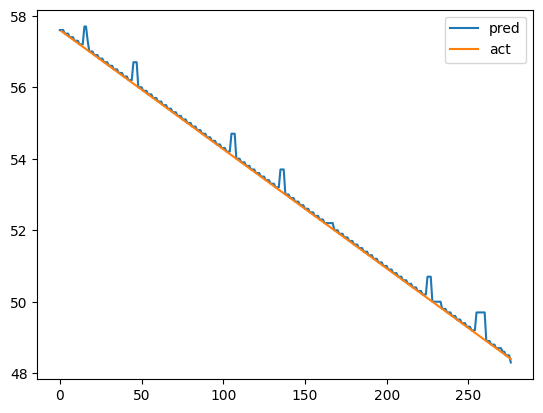

In [ ]:
import matplotlib.pyplot as plt

i = 48
ex_tr_pred = analysis[list(analysis.keys())[i]]["pred_time_remaining"]
ex_tr_act = analysis[list(analysis.keys())[i]]["act_time_remaining"]

plt.plot(ex_tr_pred)
plt.plot(ex_tr_act)

plt.legend(["pred", "act"])
plt.show()

In [ ]:
analysis